## Billie Stats Visualizer

### Quick Walkthrough
1. Edit the values of the variables in the code cell under 'User Parameters'.
2. Hit 'Run All'.
3. Scroll down to results.

### Detailed Walkthrough
There are a few parameters under 'User Parameters' that need setting.
*   ACCOUNT_ID: (optional) the encoded hash (taken from keycloak) of the account ID for which you wish to view usage. Set to None or `""` to view usage over all accounts.
*   ENV: the Billie environment that the above account is a part of (`"prod"` or `"dev"`).
*   SUM_TYPE: whether to sum over raw event values (useful for analyzing usage) or price-mapped event values (useful for billing). `count` is only available with `raw`. (`"raw"` or `"priced"`).
*   TIME: the overall time window for the analysis, correctly formatted. Example: `"2023-01-02 2023-03-04"`.
*   FREQUENCY: (optional) if specified, breaks down the time window into daily, monthly, quarterly, or yearly intervals. Leave blank to treat TIME as one chunk.

### TODOs:
*   Integration to keycloak - user supplies decoded username and KC credentials, script looks into KC for encoded username:
*   script calls 1pwd, gets kc admin pass, encodes to base64, makes into env var. second script decodes base64, gets corresponding account_id from kc, passes back.


### User Parameters
Edit the cell below with your user parameters.

In [72]:
# str: the encoded hash (from keycloak) of the account ID you wish to examine.
# Set to None or "" to view overall usage.
ACCOUNT_ID='5f0ffdae-57f8-48d6-b003-9aa70d067be2'

# str: the environment (dev/prod)
ENV="dev"

# str: start and end date for the analysis. example: "2023-01-02 2023-03-04"
TIME=f'2023-07-01 2023-07-17'

# str: time frequency. determines how many 'bins' for summing usage over time (daily/monthly/quarterly/yearly).
# Set to None or "" to treat start and end date as absolute (no breaking down over time intervals).
FREQUENCY="daily"

# str: value to examine. example: "tts.audio_duration"
VALUE_NAME="tts.input_characters" 

### Imports

In [73]:
from datetime import datetime, timedelta
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import requests

### Functions

In [74]:
def form_date_intervals(date_start, date_end, intervals):    
    """Generate date intervals on a monthly, quarterly, or daily basis, given two timepoints."""
    interval_map = {'monthly': 'MS', 'quarterly': 'QS', 'daily': 'D', 'yearly': 'Y'}
    # generate individual timepoints
    timepoints = pd.date_range(date_start, date_end, freq=interval_map[intervals]).strftime('%Y-%m-%d').tolist()
    intervals = []
    # timepoints into intervals
    for i in timepoints:
        intervals.append([i, i])
    #for i in range(len(timepoints) -1 ):
    #    intervals.append(timepoints[i: i+2])
    print(intervals)
    return intervals
    

In [75]:
url_append = f'{ACCOUNT_ID}/total' if ACCOUNT_ID else f'total'

if ENV == 'dev':
    url = f'https://billie-dev.ch.themama.ai/api/v1/billing/{url_append}'
elif ENV == 'prod':
    url = f'http://billie.ch.themama.ai/api/v1/billing/{url_append}'
    

def get_data_between_timepoints(intervals):
    interval_data = []
    headers = {'accept': 'application/json'}
    for interval in intervals:
        params = {
        'start': interval[0],
        'end': interval[1],
        'value_name': VALUE_NAME
        }
        
        response = requests.get(url, params=params, headers=headers)
        interval_data.append((interval, response.json()))
    return interval_data

In [76]:
dates_unparsed = TIME.split(" ")
date_start, date_end = datetime.strptime(dates_unparsed[0], '%Y-%m-%d'), datetime.strptime(dates_unparsed[1], '%Y-%m-%d')

if FREQUENCY:
    intervals = form_date_intervals(date_start, date_end, FREQUENCY)
else:
    intervals = [[date_start, date_end]]

r_data = get_data_between_timepoints(intervals) 

[['2023-07-01', '2023-07-01'], ['2023-07-02', '2023-07-02'], ['2023-07-03', '2023-07-03'], ['2023-07-04', '2023-07-04'], ['2023-07-05', '2023-07-05'], ['2023-07-06', '2023-07-06'], ['2023-07-07', '2023-07-07'], ['2023-07-08', '2023-07-08'], ['2023-07-09', '2023-07-09'], ['2023-07-10', '2023-07-10'], ['2023-07-11', '2023-07-11'], ['2023-07-12', '2023-07-12'], ['2023-07-13', '2023-07-13'], ['2023-07-14', '2023-07-14'], ['2023-07-15', '2023-07-15'], ['2023-07-16', '2023-07-16'], ['2023-07-17', '2023-07-17']]


Start: 2023-07-01, End: 2023-07-01, Total: 0.0, Count: 0
Start: 2023-07-02, End: 2023-07-02, Total: 0.0, Count: 0
Start: 2023-07-03, End: 2023-07-03, Total: 0.0, Count: 0
Start: 2023-07-04, End: 2023-07-04, Total: 0.0, Count: 0
Start: 2023-07-05, End: 2023-07-05, Total: 0.0, Count: 0
Start: 2023-07-06, End: 2023-07-06, Total: 0.0, Count: 0
Start: 2023-07-07, End: 2023-07-07, Total: 191908.0, Count: 797
Start: 2023-07-08, End: 2023-07-08, Total: 14028.0, Count: 42
Start: 2023-07-09, End: 2023-07-09, Total: 5826.0, Count: 19
Start: 2023-07-10, End: 2023-07-10, Total: 7122.0, Count: 25
Start: 2023-07-11, End: 2023-07-11, Total: 14356.0, Count: 39
Start: 2023-07-12, End: 2023-07-12, Total: 96956.0, Count: 282
Start: 2023-07-13, End: 2023-07-13, Total: 30414.0, Count: 87
Start: 2023-07-14, End: 2023-07-14, Total: 92274.0, Count: 278
Start: 2023-07-15, End: 2023-07-15, Total: 0.0, Count: 0
Start: 2023-07-16, End: 2023-07-16, Total: 0.0, Count: 0
Start: 2023-07-17, End: 2023-07-17, Total: 744

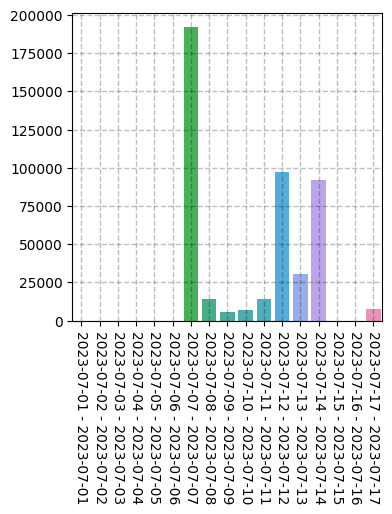

In [77]:
# print data and plot
if not r_data:
    print("Wasn't able to generate a suitable", FREQUENCY, "interval between the dates:", TIME)
    print("Please check FREQUENCY parameter.")
else:
    for interval in r_data:
            print(f"Start: {interval[0][0]}, End: {interval[0][1]}, Total: {interval[1]['total']}, Count: {interval[1]['count']}")

    y_label_val = VALUE_NAME
    y_label_count = 'Count'
    x_labels = [f'{i[0][0]} - {i[0][1]}' for i in r_data]
    plot_data_total = [i[1]['total'] for i in r_data]
    
    df = pd.DataFrame(
                      {'interval': x_labels,
                       y_label_val: plot_data_total,
                      })
    sns.barplot(x=x_labels, y=plot_data_total, data=df[[y_label_val]])
    plt.xticks(rotation=-90)
    plt.grid(color='black', linestyle='--', linewidth=1, alpha=0.25)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

